![alt text](../img/general/header_workflow.png)

# Introduction to Machine Learning

The objective of this laboratory is to introduce the basic concepts involved in the training and validation of machine learning–based models.

To this end, the MNIST and CIFAR-10 datasets will be used.

The evaluation metrics to be obtained include the confusion matrix, ROC curve, and accuracy.


Neural networks are composed of parameters and hyperparameters. Parameters are learned during training, such as the weights of the filters in a convolutional neural network (CNN). In contrast, hyperparameters are defined by the user before training begins. Hyperparameters specify both the architecture, such as the number of layers, the number of filters per layer, and the filter dimensions, as well as the learning process, including the learning rate, batch size, number of epochs, and early stopping criteria.

The main steps involved in the training and testing process are illustrated in the following figure, together with their corresponding functions.

The first two steps focus on defining the hyperparameters and configuring the machine learning architecture. Subsequently, a model summary helps to review how the model has been constructed.

Once the model is created, parameters such as the optimizer, loss function, and evaluation metrics are configured using the model.compile() function.

Finally, training is carried out using the model.fit() function, where the dataset, batch size, number of epochs, callbacks, and other options are specified.

![alt text](../img/lab01/steps_ml.png)

### Libraries


In [1]:
import os
import numpy as np
from numpy import array

import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd


## Tensorflow + Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam

## Datasets
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay


2026-01-21 16:50:46.595072: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-21 16:50:46.627618: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-21 16:50:47.183568: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### GPU

In [2]:
# GPU 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

import tensorflow as tf
print("GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

GPUs:  1


2026-01-21 16:50:47.776648: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-21 16:50:47.811390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-21 16:50:47.811703: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Dataset Loading

In this exercise, the MNIST dataset is used to train a machine learning model for classification. MNIST consists of handwritten digit images representing the ten classes from 0 to 9.

The dataset contains 70,000 grayscale images of size 28 × 28 pixels, divided into 60,000 training samples and 10,000 test samples. Each image is labeled with the corresponding digit class. Due to its simplicity and wide adoption, MNIST is commonly used as a benchmark dataset for evaluating and comparing classification algorithms.

![alt text](../img/lab01/01_lab_mnist.png)

In [3]:
# Dataset Loading: Training and Testing Sets (Data and Class Labels)
(x_train, y_train),(x_test, y_test) = mnist.load_data()


### Dataset Inspection

Visualization of sample images and labels contained in the dataset to gain an initial understanding of its structure and variability.

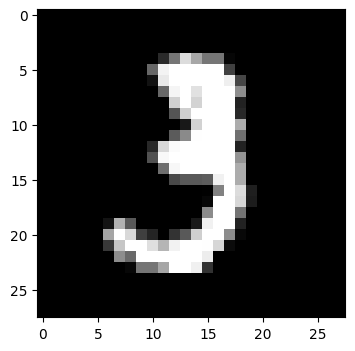

In [4]:
# Index (N) of the image in the dataset.
# Changing this value modifies the image to be displayed
N = 10

# Size of the image to be displayed
plt.figure(figsize=(4, 4))

plt.imshow(x_train[N], cmap='gray')


####  Exercise: 

Change the value of N to observe different elements of the dataset.

In [5]:
# "Shape" of the x_train variable.
# This is necessary to determine the number of samples in the dataset
# and the dimensionality of each sample.
# In this case, x_train contains 60,000 elements of size 28x28 pixels.
# The image size is important because it will be required
# when defining the machine learning–based architecture.

x_train.shape


(60000, 28, 28)

### Pre-processing

When working with images, they typically need to undergo basic pre-processing, which consists of normalizing the pixel values to the range 
[0,1], since the original pixel values lie in the range [0,255]. This is achieved by simply dividing the original pixel values by 255.

In this case, normalization is applied to the variables containing the images, *x_train* and *x_test*, since *y_train* and *y_test* contain the corresponding class labels.

In [6]:
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0

### Multilayer Perceptron (MLP) Architecture

A Multilayer Perceptron (MLP) is a feedforward neural network composed of an input layer, one or more hidden layers, and an output layer. Each layer consists of fully connected neurons, where each neuron performs a weighted sum of its inputs followed by a nonlinear activation function.

In this laboratory, the MLP architecture is used to perform image classification by learning discriminative features directly from the input pixel values. Although MLPs do not explicitly exploit spatial information as convolutional neural networks (CNNs) do, they provide a simple and effective baseline for understanding the fundamentals of neural network training and evaluation.

In [7]:
# Obtaining the width and height of the image

w = x_train_norm.shape[1]
h = x_train_norm.shape[2]


In [8]:
# Number of classes in the dataset (digits from 0 to 9)
n_classes = 10


In [9]:
# Definition of the MLP-based architecture

model_mlp = Sequential([

    # Flatten the 2D image into a 1D vector
    Flatten(input_shape=(w, h)),

    # Fully connected hidden layers with ReLU activation
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),

    # Output layer with softmax activation for multi-class classification
    Dense(n_classes, activation='softmax')

])


2026-01-21 16:50:48.331433: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x212ec8d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2026-01-21 16:50:48.331459: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Host, Default Version
2026-01-21 16:50:48.331672: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-21 16:50:48.331842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
20

#### Exercise:

What is the function of the **Flatten** layer?

In [10]:
# Display a summary of the model architecture, including layers,
# output shapes, and the number of trainable parameters
model_mlp.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 219,818
Trainable params: 219,818
Non-trainable params: 0
_________________________________________________________________


### Model Compilation

- **loss:** metric that measures how far the model’s predictions are from the true values.

    - sparse_categorical_crossentropy: used when the labels (classes) are represented as integer values.

    - categorical_crossentropy: used when the labels (classes) are one-hot encoded.

- **optimizer:** algorithm that adjusts the neural network weights in order to minimize the loss function.

    - SGD (Stochastic Gradient Descent)

    - Adam (Adaptive Moment Estimation, balances convergence speed and stability)

- **learning rate:** hyperparameter that controls the size of the weight updates performed by the optimizer at each iteration.

- **evaluation metrics:** additional values monitored during training to evaluate model performance, such as accuracy (commonly used in classification tasks).

In [11]:
# Learning rate definition
lr = 0.001

# Optimizer selection
# op = Adam(learning_rate=lr)
op = SGD(learning_rate=lr)

# Model compilation: loss function, optimizer, and evaluation metrics
model_mlp.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=op,
    metrics=['accuracy']
)


### Training

- **x_train_norm:** normalized training dataset obtained by applying a transformation to x_train.

- **y_train:** labels (or target values) corresponding to the training data.

- **batch:** number of samples processed before updating the model weights.

- **epochs:** number of times the model will iterate over the entire training dataset.

- **validation_split:** percentage of the training dataset (x_train, y_train) reserved for validation.n.

In [12]:
# Train the MLP model using the normalized training data,
# specifying the number of epochs, batch size, and validation split
history_mlp = model_mlp.fit(
    x_train_norm,
    y_train,
    epochs=32,
    batch_size=50,
    validation_split=0.2
)


# What does history_mlp contain?
# The variable history_mlp stores the training history returned by the model.fit() function. 
# It contains the values of the loss and evaluation metrics (such as accuracy) for both the training and validation sets at each epoch. 
# This information is commonly used to analyze the learning behavior of the model and to visualize training and validation curves over time.

Epoch 1/32


2026-01-21 16:50:49.011130: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2026-01-21 16:50:49.020581: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2026-01-21 16:50:49.053730: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


960/960 [==============================] - 2s 2ms/step - loss: 2.1881 - accuracy: 0.2846 - val_loss: 2.0362 - val_accuracy: 0.4353
Epoch 2/32
960/960 [==============================] - 1s 1ms/step - loss: 1.8579 - accuracy: 0.4859 - val_loss: 1.6464 - val_accuracy: 0.5450
Epoch 3/32
960/960 [==============================] - 1s 1ms/step - loss: 1.4514 - accuracy: 0.5892 - val_loss: 1.2181 - val_accuracy: 0.6640
Epoch 4/32
960/960 [==============================] - 1s 1ms/step - loss: 1.0545 - accuracy: 0.7387 - val_loss: 0.8561 - val_accuracy: 0.8135
Epoch 5/32
960/960 [==============================] - 1s 1ms/step - loss: 0.7741 - accuracy: 0.8191 - val_loss: 0.6467 - val_accuracy: 0.8475
Epoch 6/32
960/960 [==============================] - 1s 1ms/step - loss: 0.6207 - accuracy: 0.8436 - val_loss: 0.5359 - val_accuracy: 0.8657
Epoch 7/32
960/960 [==============================] - 1s 1ms/step - loss: 0.5344 - accuracy: 0.8595 - val_loss: 0.4725 - val_accuracy: 0.8755
Epoch 8/32
960/96

In [13]:
# Model evaluation on the test dataset
test_loss, test_acc = model_mlp.evaluate(x_test, y_test)

# Display test accuracy
print(f"\nTest accuracy: {test_acc:.4f}")


313/313 [==============================] - 0s 764us/step - loss: 32.3447 - accuracy: 0.9283

Test accuracy: 0.9283


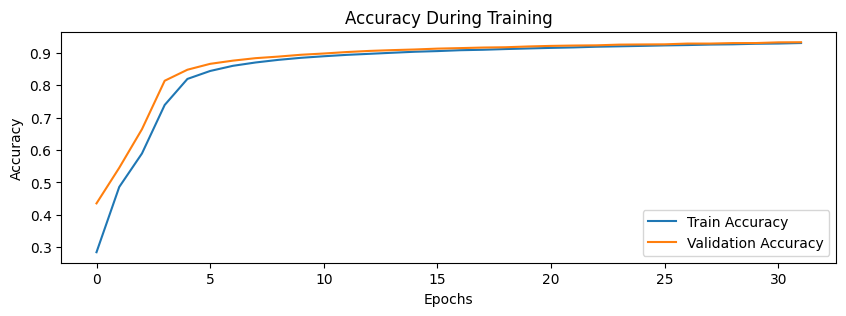

In [14]:
# Plot accuracy over epochs
plt.figure(figsize=(10, 3))

# Training and validation accuracy curves
plt.plot(history_mlp.history['accuracy'], label='Train Accuracy')
plt.plot(history_mlp.history['val_accuracy'], label='Validation Accuracy')

# Axis labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy During Training')

# Legend and display
plt.legend()
plt.show()


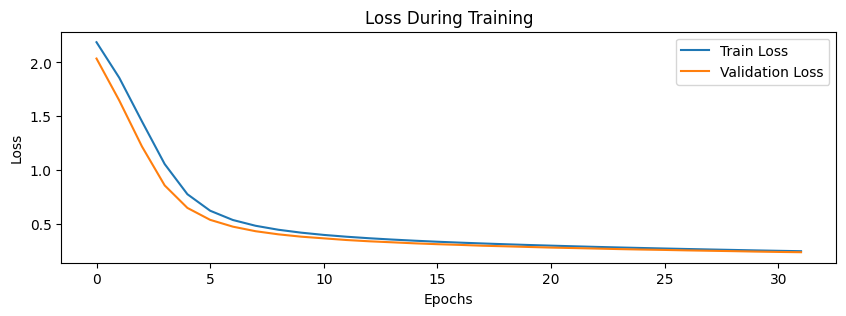

In [15]:
# Plot loss over epochs
plt.figure(figsize=(10, 3))

# Training and validation loss curves
plt.plot(history_mlp.history['loss'], label='Train Loss')
plt.plot(history_mlp.history['val_loss'], label='Validation Loss')

# Axis labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss During Training')

# Legend and display
plt.legend()
plt.show()


### Inference Testing

This allows evaluating whether the model produces reasonable predictions on unseen samples at the level of individual inputs.

1/1 [==============================] - 0s 52ms/step
Predicted Class: 9 - True Label: 9


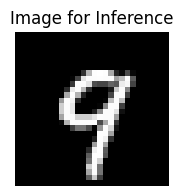

In [16]:
# Select an image index from the test set
index = 12

# Display the selected test image
plt.figure(figsize=(2, 2))
plt.imshow(x_test[index], cmap='gray')
plt.title("Image for Inference")
plt.axis('off')

# Reshape and normalize the image for model input
x_test_norm_reshaped = x_test_norm[index].reshape(-1, 28, 28)

# Perform inference
y_pred = model_mlp.predict(x_test_norm_reshaped)

# Convert predicted probabilities to class label
y_pred = np.argmax(y_pred)

# Display prediction and ground truth
print(f"Predicted Class: {y_pred} - True Label: {y_test[index]}")


In [17]:
# Perform inference on the entire test dataset
y_pred = model_mlp.predict(x_test)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)


313/313 [==============================] - 0s 493us/step


#### Metrics Report

In [18]:
# Generate a detailed classification report including precision,
# recall, F1-score, and support for each class
report_classification = classification_report(
    y_test,
    y_pred_labels,
    digits=4
)  # , output_dict=True


In [19]:
# Print the classification report
print(report_classification)

# Print the overall test accuracy
print('Average Accuracy: %.4f' % test_acc)


              precision    recall  f1-score   support

           0     0.9406    0.9857    0.9626       980
           1     0.9796    0.9727    0.9761      1135
           2     0.9091    0.9205    0.9148      1032
           3     0.9035    0.9178    0.9106      1010
           4     0.9360    0.9236    0.9298       982
           5     0.9670    0.8206    0.8878       892
           6     0.9293    0.9603    0.9446       958
           7     0.9589    0.9086    0.9331      1028
           8     0.8673    0.9394    0.9019       974
           9     0.9010    0.9197    0.9103      1009

    accuracy                         0.9283     10000
   macro avg     0.9292    0.9269    0.9272     10000
weighted avg     0.9296    0.9283    0.9281     10000

Average Accuracy: 0.9283


#### Confusion Matrix

The **confusion matrix** can be generated to analyze the model’s performance in terms of classification accuracy. It presents the prediction results in a matrix format by comparing the true values (ground-truth labels) with the predicted values.

In a binary classification problem, the confusion matrix is a 2×2 grid with the following components:

- **True Positives (TP):** Number of instances in which the model correctly predicted the positive class.

- **True Negatives (TN):** Number of instances in which the model correctly predicted the negative class.

- **False Positives (FP):** Number of instances in which the model incorrectly predicted the positive class.

- **False Negatives (FN):** Number of instances in which the model incorrectly predicted the negative class.

313/313 [==============================] - 0s 495us/step


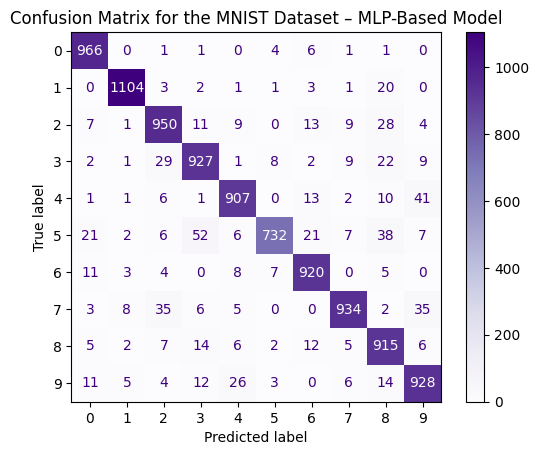

In [20]:
# Perform inference on the test dataset to obtain prediction probabilities
y_pred_probs = model_mlp.predict(x_test)

# Convert probabilities to predicted class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples')

# Add title and show the plot
plt.title('Confusion Matrix for the MNIST Dataset – MLP-Based Model')
plt.show()


#### ROC curve

The ROC (Receiver Operating Characteristic) curve is a graphical representation used to evaluate the performance of a classification model by analyzing the trade-off between the True Positive Rate (TPR) and the False Positive Rate (FPR) at different classification thresholds.

The ROC curve provides insight into the model’s ability to distinguish between classes. A curve closer to the top-left corner indicates better performance, while a curve closer to the diagonal represents a model with little discriminative power. The Area Under the Curve (AUC) is often used as a single scalar metric to summarize the overall performance.

In multi-class classification problems, such as MNIST, ROC curves are typically computed using a one-vs-rest (OvR) strategy for each class.

0.9601809769310288


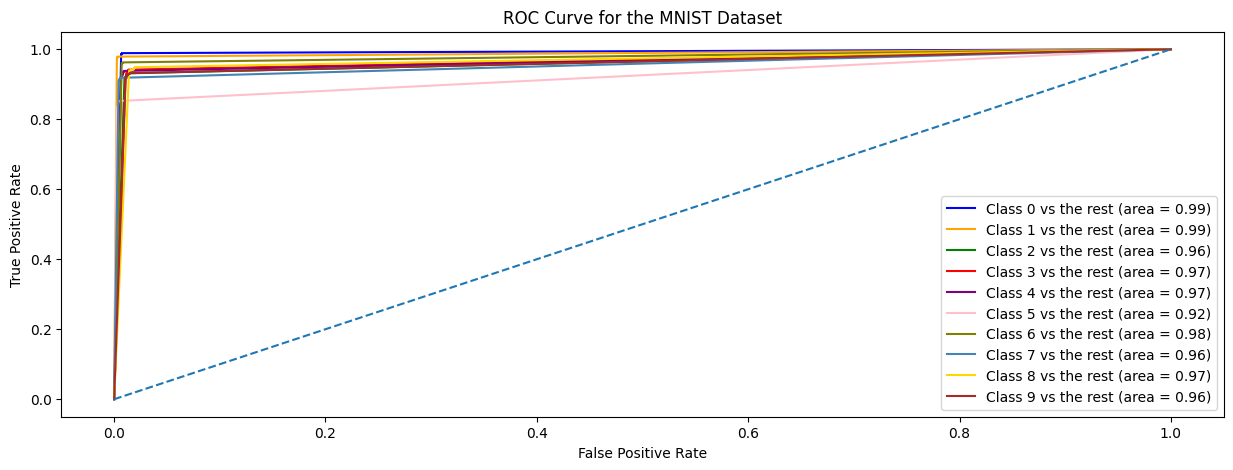

In [21]:
# Compute ROC curve and AUC for each class (one-vs-rest)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Note: roc_auc_score requires y_true and y_pred to be in one-hot (categorical) format
ycat_test = keras.utils.to_categorical(y_test, 10)
ycat_test_pred = keras.utils.to_categorical(y_pred, 10)

print(roc_auc_score(ycat_test, ycat_test_pred, multi_class='ovr', average='weighted'))

# Plot ROC curves for all classes
color = ['blue', 'orange', 'green', 'red', 'purple', 'pink', 'olive', 'steelblue', 'gold', 'brown']
plt.figure(figsize=(15, 5))

for g in range(10):
    plt.plot(
        fpr[g], tpr[g],
        color=color[g],
        label='Class %d vs the rest (area = %.2f)' % (g, roc_auc[g])
    )

# Reference line (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.title('ROC Curve for the MNIST Dataset')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


####  Exercise:

Vary the values of batch size, number of epochs, and learning rate.
Generate the corresponding training and validation curves.

What conclusions can you draw about the model’s behavior and performance when these parameters are modified?

#### Experimental Results Summary

| Experiment | Batch Size | Epochs | Learning Rate | Train Accuracy | Validation Accuracy | Test Accuracy | Observations |
|-----------|------------|--------|---------------|----------------|---------------------|---------------|--------------|
| 1 | 32 | 20 | 0.001 | | | | |
| 2 | 50 | 32 | 0.001 | | | | |
| 3 | 100 | 32 | 0.001 | | | | |
| 4 | 50 | 32 | 0.01 | | | | |
| 5 | 50 | 32 | 0.0001 | | | | |


- How does increasing the batch size affect convergence speed and stability?

- What happens when the number of epochs is too small or too large?

- How does the learning rate influence training stability and final accuracy?

- Do you observe signs of overfitting or underfitting in the curves?


#### Saving the Model

Once the model has been trained and evaluated, it can be saved to disk for later use. Saving the model allows it to be reloaded without retraining, preserving both the learned weights and the model architecture.

In [22]:
# Save the trained model to disk
model_mlp.save('../models/mnistModel_FC.h5')

---

#### One-Hot Encoding

One-Hot Encoding is a technique used to convert categorical labels into a numerical format that neural networks can process.

For example, in the MNIST dataset, the classes range from 0 to 9. Using one-hot encoding, these classes are represented as follows:

0 -> [1, 0, 0, 0, ...]

1 -> [0, 1, 0, 0, ...]

2 -> [0, 0, 1, 0, ...]

3 -> [0, 0, 0, 1, ...]

and so on for all categories present in the dataset.

**Note:**
When using one-hot encoded labels, the appropriate loss function is categorical_crossentropy, since the true labels are represented as vectors.
If the labels are instead provided as integer class indices (e.g., 0–9), the correct choice is sparse_categorical_crossentropy, which avoids the need for one-hot encoding while yielding equivalent results.

In [23]:
# Convert class labels to one-hot encoded vectors
y_train = to_categorical(y_train, num_classes=n_classes)
y_test = to_categorical(y_test, num_classes=n_classes)


In [24]:
# Display the shape of y_train to verify one-hot encoding
y_train.shape

(60000, 10)

In [25]:
# Number of classes in the dataset (digits from 0 to 9)
n_classes = 10

In [26]:
# Definition of the MLP-based architecture using one-hot encoded labels

model_oneHotEnc = Sequential([

    # Flatten the 2D image into a 1D vector
    Flatten(input_shape=(w, h)),

    # Fully connected hidden layers with ReLU activation
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),

    # Output layer with softmax activation (one neuron per class)
    Dense(n_classes, activation='softmax')

])


In [27]:
# Compile the model using categorical_crossentropy loss (required when labels are one-hot encoded)
model_oneHotEnc.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [28]:
# Train the MLP model using one-hot encoded labels
history_oneHotEnc = model_oneHotEnc.fit(
    x_train_norm,
    y_train,
    epochs=32,
    validation_split=0.2
)


Epoch 1/32


2026-01-21 16:51:32.348206: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1500/1500 [==============================] - 3s 1ms/step - loss: 0.2524 - accuracy: 0.9246 - val_loss: 0.1319 - val_accuracy: 0.9599
Epoch 2/32
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0999 - accuracy: 0.9698 - val_loss: 0.1090 - val_accuracy: 0.9676
Epoch 3/32
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0701 - accuracy: 0.9783 - val_loss: 0.1233 - val_accuracy: 0.9639
Epoch 4/32
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0533 - accuracy: 0.9824 - val_loss: 0.0935 - val_accuracy: 0.9743
Epoch 5/32
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0405 - accuracy: 0.9867 - val_loss: 0.0944 - val_accuracy: 0.9732
Epoch 6/32
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0335 - accuracy: 0.9893 - val_loss: 0.0943 - val_accuracy: 0.9754
Epoch 7/32
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0298 - accuracy: 0.9905 - val_loss: 0.1043 - val_accuracy: 0.9742
Epo

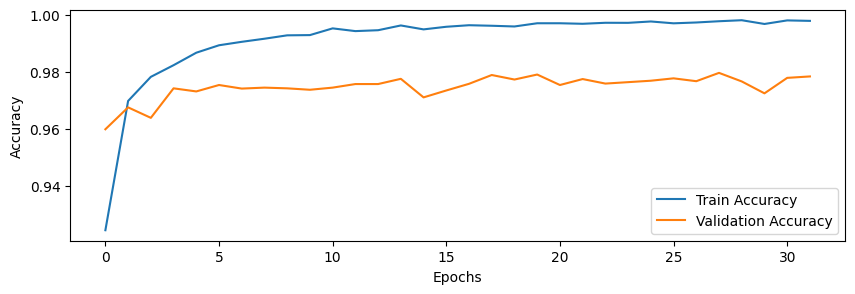

In [29]:
# Plot accuracy over epochs for the one-hot encoded model

plt.figure(figsize=(10, 3))

plt.plot(history_oneHotEnc.history['accuracy'], label='Train Accuracy')
plt.plot(history_oneHotEnc.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


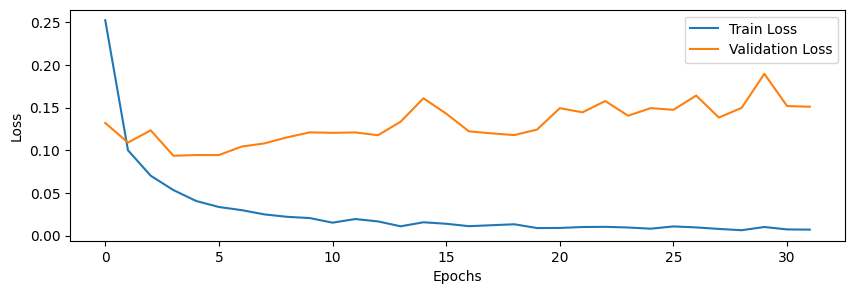

In [30]:
# Plot loss over epochs for the one-hot encoded model
plt.figure(figsize=(10, 3))

plt.plot(history_oneHotEnc.history['loss'], label='Train Loss')
plt.plot(history_oneHotEnc.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#### Exercise: Comparison Between Sparse and One-Hot Encoding

Compare the training results obtained using sparse categorical labels and one-hot encoded labels.

Analyze and discuss the following aspects:

- Training and validation accuracy: Do both approaches reach similar final accuracy values?

- Loss curves: Observe whether the loss decreases at a similar rate for both models.

- Training stability: Are there noticeable differences in convergence speed or oscillations during training?

- Computational cost: Consider the impact of one-hot encoding on memory usage and training time.



-----

### CIFAR-10 para CNN

We will repeat the previous procedure using the CIFAR-10 dataset. In this case, we will use a 2D Convolutional Neural Network (2D-CNN) architecture.

![alt text](../img/lab01/01_lab_cifar10.png)


In [31]:
# Load the CIFAR-10 dataset
(x_train_cifar10, y_train_cifar10), (x_test_cifar10, y_test_cifar10) = cifar10.load_data()


(-0.5, 31.5, 31.5, -0.5)

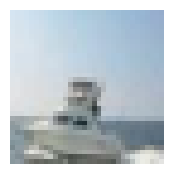

In [32]:
# Size of the image to be displayed
plt.figure(figsize=(2, 2))

# The image corresponds to the N-th element of the dataset
N = 100
plt.imshow(x_train_cifar10[N])
plt.axis('off')


In [33]:
# Normalize the CIFAR-10 dataset
x_train_cifar10_norm, x_test_cifar10_norm = (
    x_train_cifar10 / 255.0,
    x_test_cifar10 / 255.0
)


In [34]:
# Display the shape of the normalized CIFAR-10 training dataset
x_train_cifar10_norm.shape


(50000, 32, 32, 3)

In [35]:
# Definition of a 2D Convolutional Neural Network (CNN) for CIFAR-10

model_2Dconv_cifar10 = Sequential([

    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', padding='same',
           input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Third convolutional block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Flatten feature maps into a 1D vector
    Flatten(),

    # Fully connected layer
    Dense(128, activation='relu'),

    # Dropout to reduce overfitting
    Dropout(0.5),

    # Output layer for 10-class classification
    Dense(10, activation='softmax')
])


In [36]:
# Compile the CNN model
op = Adam(learning_rate=0.001)

model_2Dconv_cifar10.compile(
    optimizer=op,
    loss='sparse_categorical_crossentropy',  # Used because labels are NOT one-hot encoded
    metrics=['accuracy']
)

# Train the CNN model
history_2Dconv_cifar10 = model_2Dconv_cifar10.fit(
    x_train_cifar10_norm,
    y_train_cifar10,
    epochs=32,
    validation_split=0.2,
    batch_size=64
)


Epoch 1/32


2026-01-21 16:52:51.270877: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


625/625 [==============================] - 5s 5ms/step - loss: 1.7052 - accuracy: 0.3711 - val_loss: 1.3449 - val_accuracy: 0.5114
Epoch 2/32
625/625 [==============================] - 3s 4ms/step - loss: 1.3390 - accuracy: 0.5189 - val_loss: 1.1616 - val_accuracy: 0.5847
Epoch 3/32
625/625 [==============================] - 3s 4ms/step - loss: 1.1713 - accuracy: 0.5834 - val_loss: 1.0068 - val_accuracy: 0.6427
Epoch 4/32
625/625 [==============================] - 3s 4ms/step - loss: 1.0364 - accuracy: 0.6345 - val_loss: 0.9473 - val_accuracy: 0.6613
Epoch 5/32
625/625 [==============================] - 3s 5ms/step - loss: 0.9631 - accuracy: 0.6629 - val_loss: 0.8590 - val_accuracy: 0.6960
Epoch 6/32
625/625 [==============================] - 3s 5ms/step - loss: 0.8862 - accuracy: 0.6887 - val_loss: 0.8507 - val_accuracy: 0.7007
Epoch 7/32
625/625 [==============================] - 3s 5ms/step - loss: 0.8294 - accuracy: 0.7106 - val_loss: 0.8039 - val_accuracy: 0.7139
Epoch 8/32
625/62

In [37]:
# Evaluate the trained model on the test dataset
test_loss, test_acc = model_2Dconv_cifar10.evaluate(
    x_test_cifar10_norm,
    y_test_cifar10
)

# Display test accuracy
print(f"\nTest Accuracy: {test_acc:.4f}")


313/313 [==============================] - 1s 2ms/step - loss: 1.0901 - accuracy: 0.7343

Test Accuracy: 0.7343


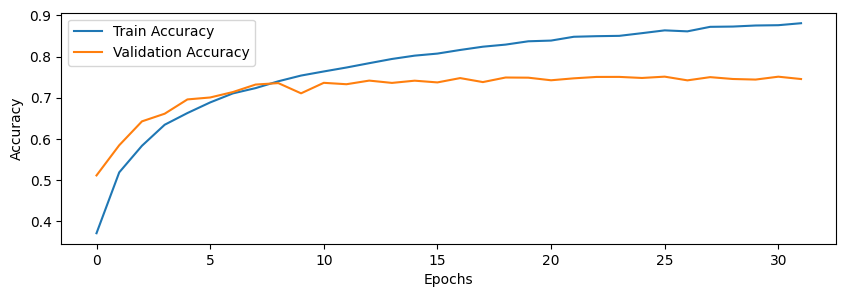

In [38]:
# Plot accuracy during training
plt.figure(figsize=(10, 3))

plt.plot(history_2Dconv_cifar10.history['accuracy'], label='Train Accuracy')
plt.plot(history_2Dconv_cifar10.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


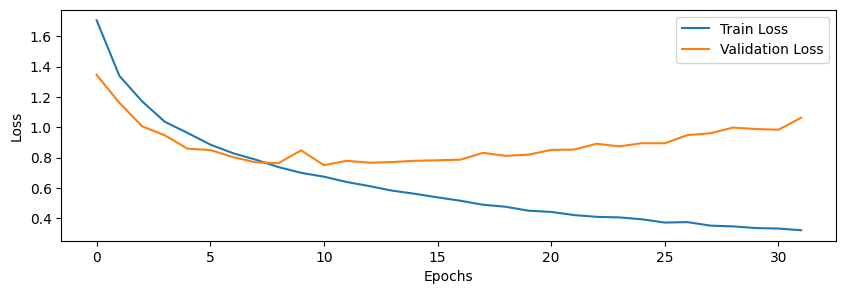

In [39]:
# Plot loss during training
plt.figure(figsize=(10, 3))

plt.plot(history_2Dconv_cifar10.history['loss'], label='Train Loss')
plt.plot(history_2Dconv_cifar10.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


--------------

#### Excercises: 

- Compute the evaluation metrics for CIFAR-10.

- For MNIST: replace the Flatten layer in the model definition with a Dense layer. For this step, the image must first be reshaped into a 1D vector.

- Repeat the previous procedure using the Fashion-MNIST and CIFAR-100 datasets.

- Compute the relevant metrics to assess and verify the model’s performance.

- For CIFAR-10: select two classes and implement a binary classifier.

![alt text](../img/lab01/01_lab_fashionmnist.png)

In [40]:
# Load the Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


In [41]:
# Load the CIFAR-100 dataset

(x_train, y_train), (x_test, y_test) = cifar100.load_data()

---
